In [39]:
### Init network Build
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import gdal
import keras
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split

%load_ext tensorboard

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

print(tf.__version__, 'tf')
print(keras.__version__, 'keras')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.3.0 tf
2.4.3 keras


In [7]:
df_merged = pd.read_csv('image_metrics_032921_all.csv')

In [41]:
df_test1 = pd.read_csv('subsets_data/test1.csv')
test1 = list(df_test1.da_number)
df_test2 = pd.read_csv('subsets_data/test2.csv')
test2 = list(df_test2.da_number)
df_train1 = pd.read_csv('subsets_data/train1.csv')
train1 = list(df_train1.da_number)
df_train2 = pd.read_csv('subsets_data/train2.csv')
train2 = list(df_train2.da_number)

In [42]:
dir2 = '/data/train_data_hi_3x/'
df_merged = pd.read_csv('image_metrics_032921_all.csv')
X = df_merged.da_num.unique()
#y = df_merged['cwa_determination']
X_train, X_test = train_test_split(X, test_size = 0.25, random_state = 42)


In [10]:
soi = list(X_train)
soi_test = list(X_test)
print(len(soi))
train_X = [f for f in Path(dir2).iterdir() if f.name[:-4] in soi]
test_X = [f for f in Path(dir2).iterdir() if f.name[:-4] in soi_test]

print(len(train_X))

9996
9913


In [11]:
train_X[0].name[:-4]

'SAW-2015-02138'

In [12]:
np.load(train_X[0]).shape

(3, 256, 256)

In [13]:
def get_label(da_num_i, df_merged = df_merged):
    return int(df_merged[df_merged.da_num == da_num_i].cwa_determination.iloc[0])
get_label(train_X[0].name[:-4])

1

In [14]:
train_y = [get_label(x.name[:-4]) for x in train_X]
test_y = [get_label(x.name[:-4]) for x in test_X]

In [15]:
print(len(train_X), len(train_y))

9913 9913


In [16]:
arr_train_X = np.array([np.load(f) for f in train_X]).swapaxes(1,3)
arr_test_X = np.array([np.load(f) for f in test_X]).swapaxes(1,3)

arr_train_y = np.array(train_y)
arr_test_y = np.array(test_y)

In [17]:
print(arr_train_X.shape)
print(arr_train_y.shape)
#print('number of nans: ', np.sum(np.isnan(arr_train_X)))
#print('number of nums: ', np.sum(~np.isnan(arr_train_X)))
#arr_train_X = np.nan_to_num(arr_train_X) #convert all nans to zeroes
#print('number of nans: ', np.sum(np.isnan(arr_train_X)))
## may need to investigate the nans and figure out some imputation here.

(9913, 256, 256, 3)
(9913,)


In [18]:
print(arr_test_X.shape)
print(arr_test_y.shape)
#print('number of nans: ', np.sum(np.isnan(arr_test_X)))
#print('number of nums: ', np.sum(~np.isnan(arr_test_X)))
#arr_test_X = np.nan_to_num(arr_test_X) #convert all nans to zeroes
#print('number of nans: ', np.sum(np.isnan(arr_test_X)))
## may need to investigate the nans and figure out some imputation here.

(3295, 256, 256, 3)
(3295,)


In [19]:
print(np.mean(arr_train_y), 'this is the majority class size.')
print(np.mean(arr_train_X))
print(np.min(arr_train_X))
print(np.max(arr_train_X))

0.37657621305356603 this is the majority class size.
0.32214305335645743
0.0
0.9999999999999999


In [14]:
np.histogram(arr_train_X[0][:,:,3:])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

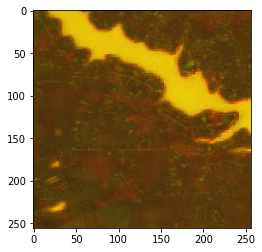

In [20]:
fig, ax = plt.subplots()
ax.imshow(arr_train_X[0])

In [21]:
!nvidia-smi

Thu Apr  1 01:16:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   63C    P0    66W / 149W |    139MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
from keras.applications.vgg16 import VGG16

vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model1.trainable = False
#vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
#vgg16_model2.trainable = False

In [23]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(256,256,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [29]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU

input_matrix = Input(shape=(256,256,3))   # 6

branch_outputs = []

# loop for however many branches you want to use.  (each branch needs 3 channel depth)
for i in [0]:
    # create looping so that vgg16 model input is created ie 256,256,3
    print(input_matrix.shape)
    out = Lambda(lambda x: x[:,:,:,i:i+3])(input_matrix)
    out = data_augmentation(out)

    print(out.shape)
    
    # Setting up your layers in each branch: (currently each branch is identical architecture.)
    if i == 0: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    elif i == 3: out = Sequential(vgg16_model2)(out)
    else: out = Sequential(vgg16_model3)(out)   # use pretrained and loaded vgg16
    print(out.shape)
#    branch_outputs.append(out)
#mergedOut = Concatenate()(branch_outputs)
mergedOut = out
print(mergedOut.shape)
mergedOut = Dense(512, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.02)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Dense(256, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.02)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Dense(128, activation=LeakyReLU(alpha = 0.1))(mergedOut)
mergedOut = LeakyReLU(alpha = 0.02)(mergedOut)
mergedOut = Dropout(.1)(mergedOut)
mergedOut = BatchNormalization()(mergedOut)

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(1, activation = 'sigmoid')(mergedOut)

rgb_model_vgg16 = Model(inputs=input_matrix, outputs=mergedOut)   


opt = keras.optimizers.Adam(learning_rate=0.05)

rgb_model_vgg16.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

rgb_model_vgg16.summary()

(None, 256, 256, 3)
(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 512)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 8, 8, 512)         14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 8, 8, 512)         262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 512)         0         
____________________________________________

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.05)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [30]:
rgb_model_vgg16.load_weights('/data/model_checkpoints/3xchan_all/low_dropout/himodel.25-0.62.h5')

In [31]:
checkpoint_filepath = '/data/model_checkpoints/3xchan_all/low_dropout/extra_low/himodel.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [23]:
i = 0
for l in rgb_model_vgg16.layers:
    print(i, l)
#    print(l.rate)
    i += 1

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f929f9620b8>
1 <tensorflow.python.keras.layers.core.Lambda object at 0x7f929f9622e8>
2 <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f929f9e3fd0>
3 <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f929f9625c0>
4 <tensorflow.python.keras.layers.core.Dense object at 0x7f929e797080>
5 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f929e797630>
6 <tensorflow.python.keras.layers.core.Dropout object at 0x7f929e7975f8>
7 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f929e75eef0>
8 <tensorflow.python.keras.layers.core.Dense object at 0x7f929e70acf8>
9 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f929e72bf60>
10 <tensorflow.python.keras.layers.core.Dropout object at 0x7f929e72b390>
11 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f929e736a20>
12 <tensorflow.py

In [32]:
t0 = time.time()
history_callback = rgb_model_vgg16.fit(arr_train_X, arr_train_y, epochs=35, 
                                       batch_size=64, validation_split = 0.2, 
                                       workers=4, use_multiprocessing=True,
                                       callbacks = [model_checkpoint_callback])
print("Train time:", time.time()-t0)

Epoch 1/35
124/124 [==============================] - 95s 764ms/step - loss: 1.1589 - accuracy: 0.6392 - val_loss: 0.6202 - val_accuracy: 0.6657
Epoch 2/35
124/124 [==============================] - 92s 739ms/step - loss: 0.7547 - accuracy: 0.6547 - val_loss: 0.6236 - val_accuracy: 0.6742
Epoch 3/35
124/124 [==============================] - 91s 736ms/step - loss: 0.6629 - accuracy: 0.6653 - val_loss: 0.6404 - val_accuracy: 0.6420
Epoch 4/35
124/124 [==============================] - 91s 737ms/step - loss: 0.6569 - accuracy: 0.6583 - val_loss: 0.6189 - val_accuracy: 0.6652
Epoch 5/35
124/124 [==============================] - 91s 737ms/step - loss: 0.7735 - accuracy: 0.6415 - val_loss: 0.7292 - val_accuracy: 0.6641
Epoch 6/35
124/124 [==============================] - 91s 737ms/step - loss: 0.7422 - accuracy: 0.6456 - val_loss: 0.8180 - val_accuracy: 0.6505
Epoch 7/35
124/124 [==============================] - 92s 740ms/step - loss: 0.6908 - accuracy: 0.6463 - val_loss: 0.6377 - val_ac

KeyboardInterrupt: 

In [63]:
#run1 = history_callback.history
run2 = history_callback.history


In [53]:
#model_out.save('/data/model_saves/89_model') 89 model saved mar 18

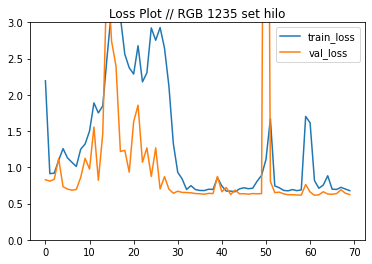

In [64]:
train_loss = run1['loss'] + run2['loss']
val_loss = run1['val_loss'] + run2['val_loss']
x = np.arange(len(train_loss))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x, train_loss, label='train_loss')
ax.plot(x, val_loss, label='val_loss')
ax.set_ylim(0, 3) 
plt.title('Loss Plot // RGB 1235 set hilo')
ax.legend()
plt.show()

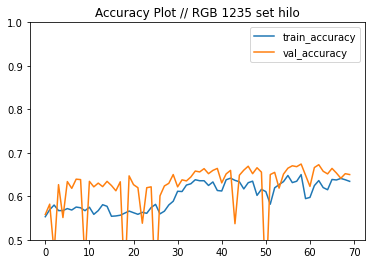

In [65]:
train_accuracy = run1['accuracy'] + run2['accuracy']
val_accuracy = run1['val_accuracy'] + run2['val_accuracy']
x = np.arange(len(train_accuracy))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x, train_accuracy, label='train_accuracy')
ax.plot(x, val_accuracy, label='val_accuracy')
ax.set_ylim(0.5, 1) 
plt.title('Accuracy Plot // RGB 1235 set hilo')
ax.legend()
plt.show()

In [56]:
np.mean(arr_train_y)

0.37657621305356603

In [57]:
np.mean(arr_test_y)

0.37481031866464337

In [33]:
rgb_model_vgg16.load_weights('/data/model_checkpoints/3xchan_all/low_dropout/extra_low/himodel.07-0.64.h5')

In [34]:
test_preds = rgb_model_vgg16.predict(arr_test_X, batch_size = 128)
print(test_preds[:8])

[[0.42622924]
 [0.29693335]
 [0.3619465 ]
 [0.30237392]
 [0.3603746 ]
 [0.3897093 ]
 [0.2652666 ]
 [0.47581   ]]


In [35]:
#print(len(rounded_preds))
rounded_preds = np.round(test_preds)
rounded_preds[:8]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [38]:
da_n = [x.name[:-4] for x in test_X]
df_pred = pd.DataFrame({'da_number' : da_n, 'predicted' : list(rounded_preds), 'cwa_determination' : test_y})
df_pred.predicted = df_pred.predicted.apply(int)
print(df_pred.dtypes)
display(df_pred.head())
df_pred.to_csv('/data/model_checkpoints/3xchan_all/himodel_preds.csv')
false_neg = df_pred[(df_pred.predicted == 0)&(df_pred.cwa_determination == 1)].shape[0]
false_pos = df_pred[(df_pred.predicted == 1)&(df_pred.cwa_determination == 0)].shape[0]
true_pos = df_pred[(df_pred.predicted == 1)&(df_pred.cwa_determination == 1)].shape[0]
true_neg = df_pred[(df_pred.predicted == 0)&(df_pred.cwa_determination == 0)].shape[0]
print('false_neg:', false_neg)
print('false_pos:', false_pos)
print('true_pos:', true_pos)
print('true_neg:', true_neg)
print(true_pos/(false_neg+true_pos))
print(true_neg/(false_pos+true_neg))
print(true_pos/(false_pos+true_pos))

da_number            object
predicted             int64
cwa_determination     int64
dtype: object


,da_number,predicted,cwa_determination
0,SAC-2015-00882,0,0
1,LRL-2018-00430-sjk,0,1
2,SAC-2016-00908,0,0
3,LRL-2019-00353,0,0
4,MVP-2020-00700-AJK,0,0


false_neg: 884
false_pos: 203
true_pos: 351
true_neg: 1857
0.28421052631578947
0.9014563106796116
0.6335740072202166


In [ ]:
1968/2060 = specficity = 95.5
231/1235 = sensitivity = 18.7

da_number	predicted	cwa_determination
0	SAC-2015-00882	0	0
1	LRL-2018-00430-sjk	0	1
2	SAC-2016-00908	0	0
3	LRL-2019-00353	0	0
4	MVP-2020-00700-AJK	0	0
false_neg: 1004
false_pos: 92
true_pos: 231
true_neg: 1968